In [1]:
# importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
import glob
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt 


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import glob



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
images_directory = '/content/drive/My Drive/Flickr_Data/'

img_path = '/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/'
cap_path = '/content/drive/My Drive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
training_path = '/content/drive/My Drive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
valid_path = '/content/drive/My Drive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
testing_path  = '/content/drive/My Drive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

cap = open(cap_path, 'r').read().split("\n")
x_training = open(training_path, 'r').read().split("\n")
x_valid = open(valid_path, 'r').read().split("\n")
x_testing = open(testing_path , 'r').read().split("\n")

In [4]:
# Loading cap as values and images as key in dictionary
tok = {}

for item in range(len(cap)-1):
    tem = cap[item].split("#") #tem[0]= imgname.jpg ..... tem[1]=0  captionn.
    if tem[0] in tok:
        tok[tem[0]].append(tem[1][2:])
    else:
        tok[tem[0]] = [tem[1][2:]] #tem[n]= imgName ... #tok[tem[n]] = list of caption


In [5]:
# Making 3 files with 2 colmns as 'image_id' and 'captions'
training_dataset = open('flickr_8k_train_dataset.txt','wb')
training_dataset.write(b"image_id\tcap\n")

valid_dataset = open('flickr_8k_val_dataset.txt','wb')
valid_dataset.write(b"image_id\tcap\n")

testing_dataset = open('flickr_8k_test_dataset.txt','wb')
testing_dataset.write(b"image_id\tcap\n")


13

In [6]:
# Loading image ids and captions for each of these images in the above 3 files
for img in x_training:
    if img == '':
        continue
    for capt in tok[img]:
        caption = "<start> "+ capt + " <end>"
        training_dataset.write((img+"\t"+caption+"\n").encode())
        training_dataset.flush()
training_dataset.close()

for img in x_testing:
    if img == '':
        continue
    for capt in tok[img]:
        caption = "<start> "+ capt + " <end>"
        testing_dataset.write((img+"\t"+caption+"\n").encode())
        testing_dataset.flush()
testing_dataset.close()

for img in x_valid:
    if img == '':
        continue
    for capt in tok[img]:
        caption = "<start> "+ capt + " <end>"
        valid_dataset.write((img+"\t"+caption+"\n").encode())
        valid_dataset.flush()
valid_dataset.close()

In [7]:
# Here, we're using ResNet50 Model
from IPython.core.display import display, HTML
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

94658560/94653016 [==============================] - 8s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

In [8]:
#  process images to target size
def preprocess(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im) # (x, y, z)
    im = np.expand_dims(im, axis=0)  # (0, x, y, z)
    return im

In [9]:
training_data = {}
counter=0
for item in x_training:
    if item == "":
        continue
    if counter >= 3000:
        break
    counter+=1
    if counter%1000==0:
        print(counter)
    path = img_path + item
    img = preprocess(path) #to change the dimensions of the image for using ResNet model
    pred = model.predict(img).reshape(2048)  # shape of each image is (2048, 0)
    training_data[item] = pred 

1000
2000
3000


In [10]:
# opening train_enc_img.p file and dumping content of training_data to this file
with open( "train_enc_img.p", "wb" ) as pickle_f: #obj hierarchy is converted into byte stream
    pickle.dump(training_data, pickle_f ) 

In [11]:
# Storing image and its corresponding caption into a dataframe 
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
dframe = pd_dataset.values
print(dframe.shape)

(30000, 2)


In [12]:
pd_dataset.head()

,image_id,cap
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [13]:
# Storing all the captions from dframe into a list
senten = []
for item in range(dframe.shape[0]):
    senten.append(dframe[item, 1])
#senten will have 30000 length
# First 5 captions stored in senten
senten[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [14]:
# Splitting each captions stored in 'senten' and storing them in 'wor' as list of list
wor = [i.split() for i in senten]

In [15]:
# Creating a list of all unique wor
uniq = []
for i in wor:
    uniq.extend(i)
uniq = list(set(uniq))

print(len(uniq))

vocabulary_size = len(uniq)

8253


In [16]:
# making 2 lists to index each unique word and vice-versa
w_to_i = {val:index for index, val in enumerate(uniq)}
i_to_w = {index:val for index, val in enumerate(uniq)}

In [17]:
w_to_i['UNK'] = 0
w_to_i['raining'] = 8253
i_to_w[0] = 'UNK'
i_to_w[8253] = 'raining'

In [18]:
vocabulary_size = len(w_to_i.keys())
print(vocabulary_size)

8254


In [19]:
max_len = 0

for i in senten:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len) #finding longest caption

40


In [20]:
pad_seq, subsequent_wor = [], []

for item in range(dframe.shape[0]):  #30000 items
    part_seq = []
    next_wor = []
    text = dframe[item, 1].split() #diving each caption for every image into words
    text = [w_to_i[i] for i in text] #finding index for each word
    for i in range(1, len(text)):
        part_seq.append(text[:i])  #start, 1st word, ... , last word
        next_wor.append(text[i])   #1st word, ... , last word, end
    pad_part_seq  = sequence.pad_sequences(part_seq, max_len, padding='post')

    next_wor_1hot = np.zeros([len(next_wor), vocabulary_size], dtype=np.bool)
    
    for i,next_word in enumerate(next_wor):
        next_wor_1hot[i, next_word] = 1
        
    pad_seq.append(pad_part_seq )
    subsequent_wor.append(next_wor_1hot)
    
pad_seq = np.asarray(pad_seq)
subsequent_wor = np.asarray(subsequent_wor)

print(pad_seq.shape)
print(subsequent_wor.shape)

(30000,)
(30000,)


In [21]:
print(pad_seq[0])

[[3730    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3730 1633    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3730 1633 8025    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3730 1633 8025 2695    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3730 1633 8025 2695 6914    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [22]:
for item in range(len(pad_seq[0])):
    for y in range(max_len):
        print(i_to_w[pad_seq[0][item][y]],)
    print("\n")

print(len(pad_seq[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [23]:
num_imgs = 2000

In [24]:
cap = np.zeros([0, max_len])
next_wor = np.zeros([0, vocabulary_size])

In [25]:
for item in range(num_imgs): #img_to_padded_seqs.shape[0]):
    cap = np.concatenate([cap, pad_seq[item]])
    next_wor = np.concatenate([next_wor, subsequent_wor[item]])

np.save("cap.npy", cap)
np.save("next_wor.npy", next_wor)

print(cap.shape)
print(next_wor.shape)

(25493, 40)
(25493, 8254)


In [26]:
with open('train_enc_img.p', 'rb') as f:
    enc_img = pickle.load(f, encoding="bytes")

In [27]:
imgs = []

for item in range(dframe.shape[0]): #30000

    if dframe[item, 0] in enc_img.keys(): #dframe[0,0], [1,0], ... , [4,0] match with 0th key of enc_img
      
        imgs.append(list(enc_img[dframe[item, 0]])) 

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [28]:
images = []
img_names = []

for item in range(num_imgs):  #2000
    for y in range(pad_seq[item].shape[0]): #14
        images.append(imgs[item]) #1st iteration: 14 times name of image in byte form
        img_names.append(dframe[item, 0]) # normal form
        
images = np.asarray(images) #images contains image_name in byte form
np.save("images.npy", images)

img_names = np.asarray(img_names) #img_names contains image_name normally
np.save("img_names.npy", img_names)

print(images.shape)
print(len(img_names))

(25493, 2048)
25493


In [29]:
cap = np.load("cap.npy")
next_wor = np.load("next_wor.npy")

print(cap.shape)
print(next_wor.shape)

(25493, 40)
(25493, 8254)


In [30]:
images = np.load("images.npy")
print(images.shape)

(25493, 2048)


In [31]:
imag = np.load("img_names.npy")
print(imag.shape)

(25493,)


In [32]:
embed_size = 128
max_len = 40

In [33]:
img_model = Sequential()

img_model.add(Dense(embed_size, input_shape=(2048,), activation='relu'))
img_model.add(RepeatVector(max_len))

img_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [34]:
lang_model = Sequential()

lang_model.add(Embedding(input_dim=vocabulary_size, output_dim=embed_size, input_length=max_len))
lang_model.add(LSTM(256, return_sequences=True))
lang_model.add(TimeDistributed(Dense(embed_size)))

lang_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [35]:
concat = Concatenate()([img_model.output, lang_model.output])
x = LSTM(128, return_sequences=True)(concat)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocabulary_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[img_model.input, lang_model.input], outputs = out)

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      dense_1_input[0][0]              
____________________________________________________________________________________________

In [37]:
hist = model.fit([images, cap], next_wor, batch_size=512, epochs=210)

Epoch 1/210
25493/25493 [==============================] - 24s 927us/step - loss: 4.6931 - accuracy: 0.1633
Epoch 2/210
25493/25493 [==============================] - 24s 927us/step - loss: 4.5487 - accuracy: 0.1892
Epoch 3/210
25493/25493 [==============================] - 24s 929us/step - loss: 4.4287 - accuracy: 0.2074
Epoch 4/210
25493/25493 [==============================] - 24s 926us/step - loss: 4.3111 - accuracy: 0.2259
Epoch 5/210
25493/25493 [==============================] - 23s 919us/step - loss: 4.1707 - accuracy: 0.2532
Epoch 6/210
25493/25493 [==============================] - 23s 920us/step - loss: 4.1277 - accuracy: 0.2517
Epoch 7/210
25493/25493 [==============================] - 24s 929us/step - loss: 4.0666 - accuracy: 0.2590
Epoch 8/210
25493/25493 [==============================] - 24s 926us/step - loss: 4.0029 - accuracy: 0.2605
Epoch 9/210
25493/25493 [==============================] - 24s 923us/step - loss: 3.9429 - accuracy: 0.2656
Epoch 10/210
25493/25493 [==

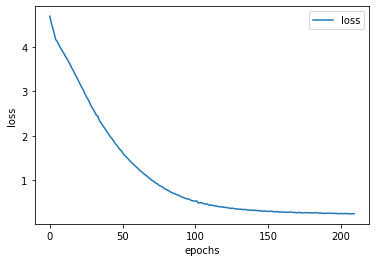

In [38]:
for label in ["loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

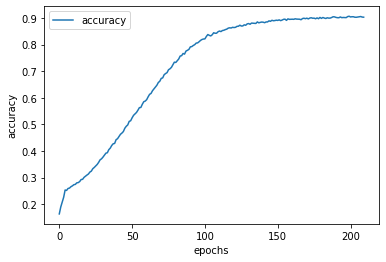

In [39]:
for label in ["accuracy"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [40]:
model.save_weights("model_weights.h5")

In [41]:
def preprocess(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im) #(224,224,3)
    im = np.expand_dims(im, axis=0) #(1,224,224,3)
    return im

In [42]:
def get_encode(model, img):
    image = preprocess(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [43]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [61]:
img = "/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/3376942201_2c45d99237.jpg"
test_img = get_encode(resnet, img)

In [62]:
def predict_cap(image):
    start_wor = ["<start>"]
    
    while True:
        par_cap = [w_to_i[i] for i in start_wor] #par_cap list is made
        par_cap = sequence.pad_sequences([par_cap], maxlen=max_len, padding='post') #convert list to sequence of len = 40
        preds = model.predict([np.array([image]), np.array(par_cap)]) # PREDICTION
        xx = np.argmax(preds[0])       
        word_pred = i_to_w[xx] # convert 5972 to DOG
        start_wor.append(word_pred) # [dog] is added in list
        
        if word_pred == "<end>" or len(start_wor) > max_len:
            break
            
    return ' '.join(start_wor[1:-1])

final_caption = predict_cap(test_img)

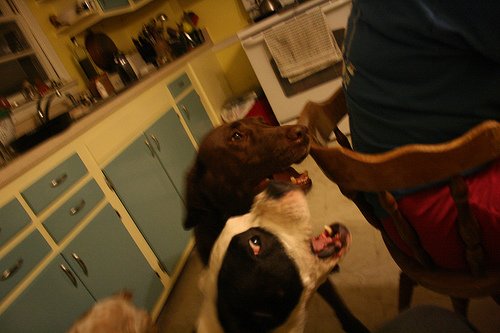

A dog in a headwraps pushes two down a man to the seat .


In [63]:
from IPython.display import Image,display
z = Image(filename=img)
display(z)

print(final_caption)

In [70]:
img = "/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1.jpg"
test_img = get_encode(resnet, img)

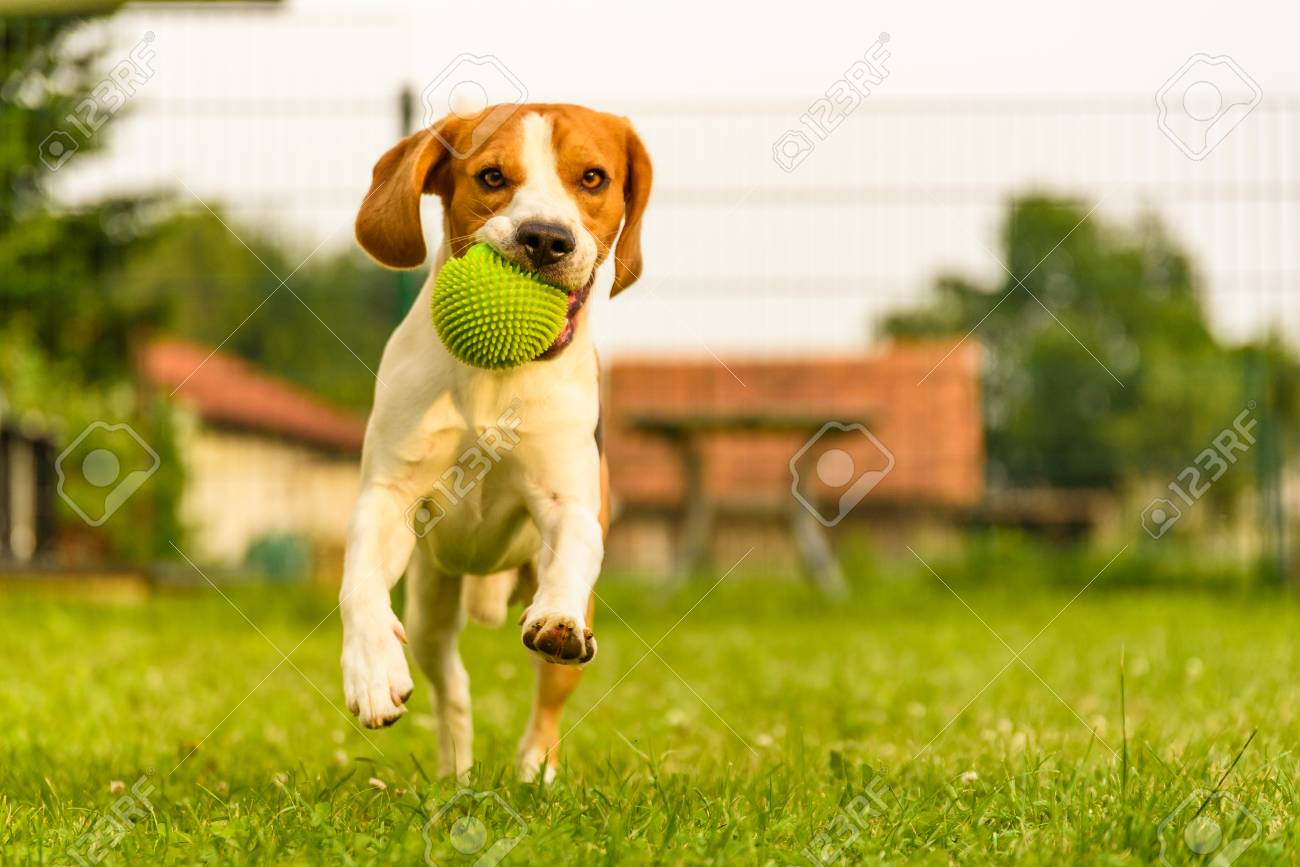

A black and white dog is playing with a ball to to its grass .


In [71]:
from IPython.display import Image,display
final_caption = predict_cap(test_img)
z = Image(filename=img)
display(z)

print(final_caption)

In [91]:
img = "/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/car.jpg"
test_img = get_encode(resnet, img)

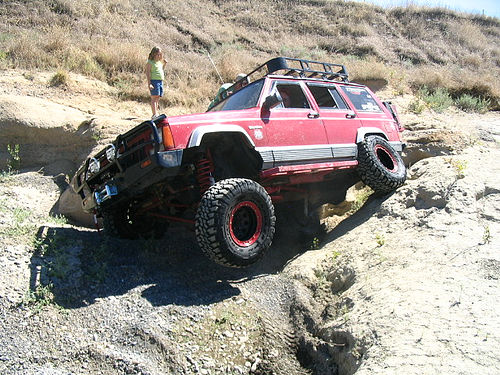

A group of people are steamboat on a rocky road .


In [92]:
from IPython.display import Image,display
final_caption = predict_cap(test_img)
z = Image(filename=img)
display(z)

print(final_caption)

In [100]:
img = "/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/bike.jpg"
test_img = get_encode(resnet, img)

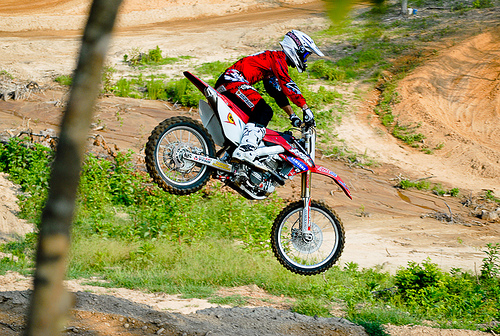

A man wearing a helmet riding glove to a red helmet wearing a help .


In [101]:
from IPython.display import Image,display
final_caption = predict_cap(test_img)
z = Image(filename=img)
display(z)

print(final_caption)

In [104]:
img = "/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/tennis.jpg"
test_img = get_encode(resnet, img)

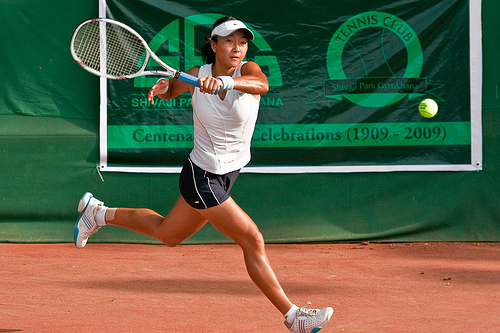

A kid of girl is playing by a ball with a and ball on kick other .


In [105]:
from IPython.display import Image,display
final_caption = predict_cap(test_img)
z = Image(filename=img)
display(z)

print(final_caption)